In [112]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import string
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report, plot_roc_curve, auc, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from wordcloud import WordCloud,STOPWORDS
from sklearn.dummy import DummyClassifier
warnings.filterwarnings('ignore')

## 1. EDA

### 1.1 Explore & Clean Up Data

In [3]:
# Import Dataset
df = pd.read_csv("news 2.csv")

In [4]:
df.sample(10)

,Unnamed: 0,title,text,label
5277,9522,"The Oil-Gas War Over Syria, in Maps","The Oil-Gas War Over Syria, in Maps Eric Zuess...",FAKE
6110,7188,BREAKING : Sources Inside the FBI Say Hillary ...,BREAKING : Sources Inside the FBI Say Hillary ...,FAKE
4098,2745,You really expect me to believe that? Hillary ...,"Reporter: Mr. President, when did you first le...",REAL
4839,7813,Email Reveals What Progressive Think Tank Gain...,"When a prominent, progressive establishment th...",FAKE
5890,8362,Associated Press reporter admits faking news s...,"*Sent:* Tuesday, August 11, 2015 6:00 PM *To:*...",FAKE
431,4147,"U.S. Economy Added 271,000 Jobs In October, Be...",In a jobs report that may influence the Federa...,REAL
2937,4695,Fight night in Las Vegas: High stakes for Trum...,Chris Wallace has got his work cut out for him...,REAL
3045,647,Bernie Sanders is expected to endorse Hillary ...,It's amazing to go back and watch Bernie Sande...,REAL
5833,8659,Re: Early Voting Results In Key Battleground S...,Early Voting Results In Key Battleground State...,FAKE
4941,1202,Clinton regrets 1996 remark on ‘super-predator...,"COLUMBIA, S.C. — Black voters are the linchpin...",REAL


It seems like most of the news are political within political category.

In [5]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

Null value does not exist within the dataset.

In [6]:
# Combine Title into text and drop title from the dataframe.
df['text'] = df['title'] + df['text']
df.drop('title', inplace=True, axis=1)

In [66]:
df.head()

,Unnamed: 0,text,label,words_used
0,8476,"You Can Smell Hillary’s FearDaniel Greenfield,...",FAKE,1300.0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,459.0
2,3608,Kerry to go to Paris in gesture of sympathyU.S...,REAL,439.0
3,10142,Bernie supporters on Twitter erupt in anger ag...,FAKE,418.0
4,875,The Battle of New York: Why This Primary Matte...,REAL,325.0


In [7]:
# Clean up X and y Dataset for future use.
X = df.drop(['Unnamed: 0','label'], axis=1)
y = df['label']

### 1.2 Explore Data

In [8]:
df["words_used"] = np.nan

In [9]:
## See how may words are used per text
for i in range(len(df.text)-1):
    df['words_used'].iloc[i] = len(df['text'].iloc[i].split())

In [10]:
df_words = df.groupby('label').agg({'words_used':['mean', 'median', 'std', 'min', 'max']})

In [11]:
res = len(df['text'].iloc[1].split())

In [13]:
df_words

words_used                                  
             mean median         std   min      max
label                                              
FAKE   689.353034  432.0  958.966693   3.0  20903.0
REAL   882.134385  780.5  723.131382  11.0   7625.0

FAKE news articles contains less mean & median number of words whereas their standard deviation is a lot larger indicating they have more versatility in lengh of an article.

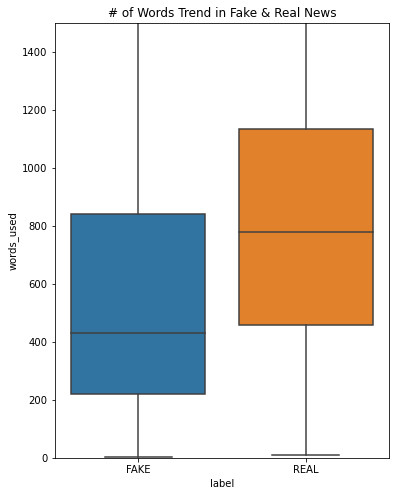

In [42]:
fig, ax = plt.subplots(figsize=(6,8))
ax = sns.boxplot(x='label', y='words_used', data=df)
ax.set_ylim(0,1500)
ax.set_title('# of Words Trend in Fake & Real News')
plt.show();

Overally, FAKE news has lower spectrum of length compared to REAL news.

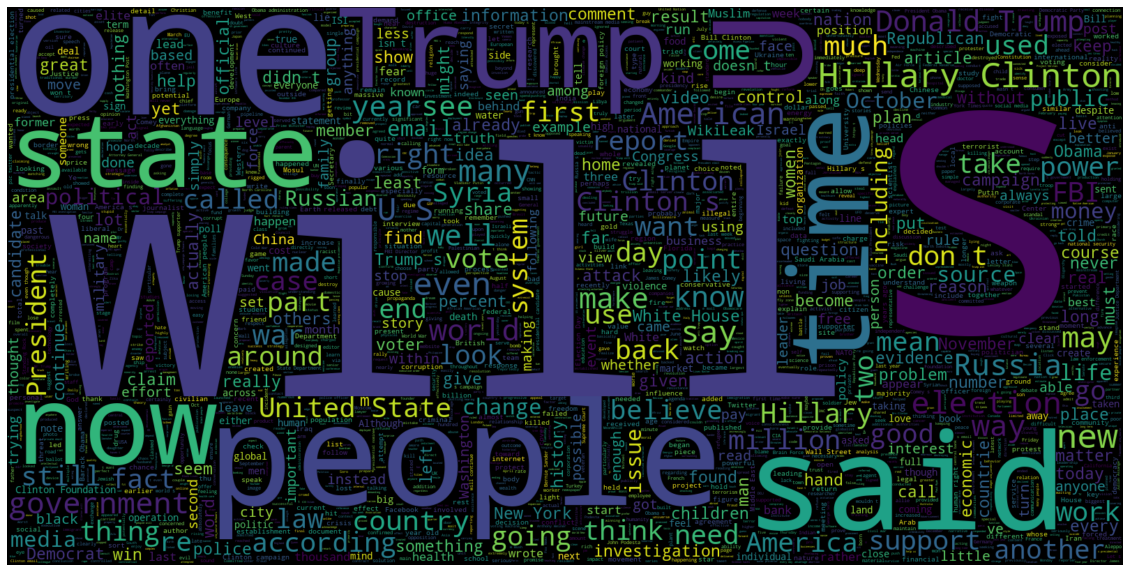

In [64]:
# Fake News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'FAKE'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show;

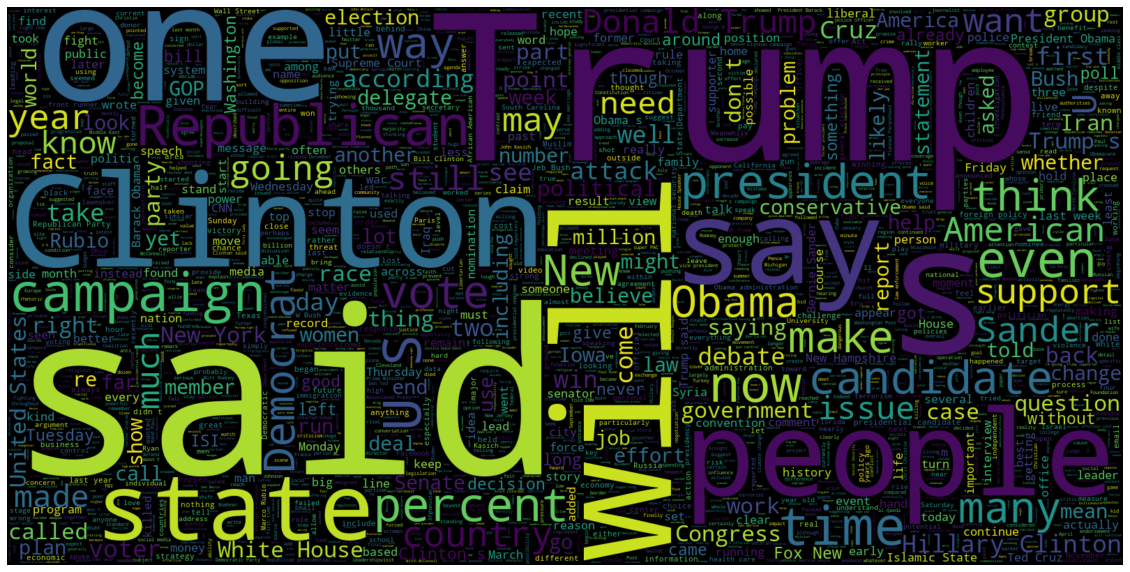

In [59]:
# Real News Word Cloud
plt.figure(figsize = (20,20)) # Text from the real news articles
wc = WordCloud(max_words = 3000 , width = 1600 , height = 800 , 
               stopwords = STOPWORDS).generate(" ".join(df[df.label == 'REAL'].text))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")
plt.show;

Looking at word Cloud, it's hard to tell the distinction between two types of articles. However, it is evident that both articles are mainly about the US politics.

## 2. Modeling

## 2.1 Splitting Dataset for Modeling.

First, we try general model without fixing class balance.

In [70]:
X = df['text']
y = df['label']

In [71]:
#DataFlair - Split the dataset
x_train,x_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=7)

In [72]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english', 
                                 max_df=0.7,
                                 min_df=5)

#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test) 

In [73]:
print('TF-IDF Train:',tfidf_train.shape)
print('TF-IDF Test:',tfidf_test.shape)

TF-IDF Train: (5068, 21472)
TF-IDF Test: (1267, 21472)


### 2.1.1 Decision Tree Model

In [77]:
Tree_clf = DecisionTreeClassifier(max_depth = 10)

In [78]:
# Perform Cross Validation
k_fold = 10
Tree_cv_score = cross_val_score(estimator=Tree_clf, X=tfidf_train,
                        y=y_train, cv=k_fold)

In [79]:
np.mean(Tree_cv_score)

0.8145282253977907

K-fold Cross Validation Score seems to be uniform and accurate.

In [81]:
# Fit the model to the TF-IDF features
Tree_tfidf = Tree_clf.fit(tfidf_train, y_train)

### 2.1.2 Decision Tree Model Evaluation

In [89]:
# Predicting the model for tf-idf features
Tree_tfidf_pred = Tree_clf.predict(tfidf_test)

In [91]:
# Check the accuracy score for tfidf features
Tree_tfidf_score=accuracy_score(y_test, Tree_tfidf_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfidf_score)

Decision Tree TF-IDF accuracy score: 0.8082083662194159


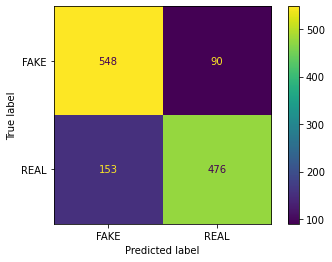

In [95]:
Tree_cm = plot_confusion_matrix(Tree_clf, tfidf_test, y_test);

Result seems not too bad!

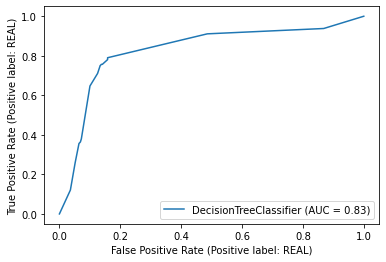

In [96]:
Tree_roc = plot_roc_curve(Tree_clf ,tfidf_test,y_test)

In [98]:
Tree_tfidf_report = classification_report(y_test, Tree_tfidf_pred, target_names = ['FAKE','REAL'])
print(Tree_tfidf_report)

              precision    recall  f1-score   support

        FAKE       0.78      0.86      0.82       638
        REAL       0.84      0.76      0.80       629

    accuracy                           0.81      1267
   macro avg       0.81      0.81      0.81      1267
weighted avg       0.81      0.81      0.81      1267



## 2.2 Data Split Tweak

By the numbers: In 2020, nearly one-fifth <b>(17%)</b> of engagement among the top 100 news sources on social media came from sources that NewsGuard deems generally unreliable, compared to about 8% in 2019.<br>
<br>
Source = https://www.axios.com/unreliable-news-sources-social-media-engagement-297bf046-c1b0-4e69-9875-05443b1dca73.html?utm_campaign=organic&utm_medium=socialshare&utm_source=twitter

<B>Entire Dataset will be re-sampled into 0.17:1.0 FAKE to REAL news ratio so that it actually resembles FAKE news ratio being spread in the real world.

In [99]:
from imblearn.datasets import make_imbalance

In [100]:
X = pd.DataFrame(X)

In [101]:
# Create imbalanced Dataset (0.17:1 Fake vs. Real News Ratio)
x_im, y_im = make_imbalance(X,y,sampling_strategy={'FAKE': 539, 'REAL': 3171})

In [102]:
# Check the Dataset
y_im.value_counts()

REAL    3171
FAKE     539
Name: label, dtype: int64

In [103]:
x_im = x_im['text']

In [104]:
#DataFlair - Split the dataset
x_train, x_test, y_train, y_test = train_test_split(x_im, y_im, test_size=0.2, random_state=7)

In [105]:
y_train.value_counts()

REAL    2533
FAKE     435
Name: label, dtype: int64

In [106]:
#DataFlair - Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

#DataFlair - Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train)
tfidf_test=tfidf_vectorizer.transform(x_test) 

In [107]:
print('TF-IDF Train:',tfidf_train.shape)
print('TF-IDF Test:',tfidf_test.shape)

TF-IDF Train: (2968, 47048)
TF-IDF Test: (742, 47048)


### 2.2.1 Dummy Model

Dummy Model needs to be built to compare performance going forward as Target Variable class is highly imbalanced.

In [113]:
# fit X_tran, y_train in dummy model
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(tfidf_train, y_train)

DummyClassifier(strategy='most_frequent')

In [114]:
# Predicting the model for tf-idf features
dummy_pred = dummy_model.predict(tfidf_test)

In [115]:
# Check the accuracy score for tfidf features
dummy_score=accuracy_score(y_test, dummy_pred)
print("Decision Tree TF-IDF accuracy score:", dummy_score)

Decision Tree TF-IDF accuracy score: 0.8598382749326146


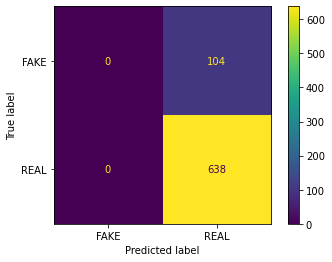

In [116]:
dummy_cm = plot_confusion_matrix(dummy_model, tfidf_test, y_test);

Since Dummy Model has Accuracy score of 0.86, any model that has less than 0.86 accuracy score is not viable at all.

### 2.2.2 Decision Tree Model after Data Split

In [121]:
np.linspace(4,20,5)

array([ 4.,  8., 12., 16., 20.])

In [117]:
Tree_clf_im = DecisionTreeClassifier()

In [122]:
# Test optimal hyperparameter through cross validation.
k_fold = 10
for i in np.linspace(4,20,5).astype(int):
    Tree_clf_im = DecisionTreeClassifier(max_depth = i)
    Tree_clf_im_score = cross_val_score(estimator=Tree_clf_im, X=tfidf_train,
                        y=y_train, cv=k_fold)
    print("max_depth " + str(i) + " :"+ str(np.round(np.mean(Tree_clf_im_score)*100,2)))

max_depth 4 :87.5
max_depth 8 :88.24
max_depth 12 :87.4
max_depth 16 :87.74
max_depth 20 :87.47


Optimum max_depth parameter = 8

In [131]:
# Set the max_depth parameter as 8
Tree_clf_im = DecisionTreeClassifier(max_depth=8)

In [132]:
# Fit the model to the TF-IDF features
Tree_tfidf_im = Tree_clf_im.fit(tfidf_train, y_train)

In [133]:
# Predicting the model for tf-idf features
Tree_tfidf_im_pred = Tree_clf_im.predict(tfidf_test)

In [134]:
# Check the accuracy score for tfidf features
Tree_tfidf_im_score=accuracy_score(y_test, Tree_tfidf_im_pred)
print("Decision Tree TF-IDF accuracy score:", Tree_tfidf_im_score)

Decision Tree TF-IDF accuracy score: 0.8787061994609164


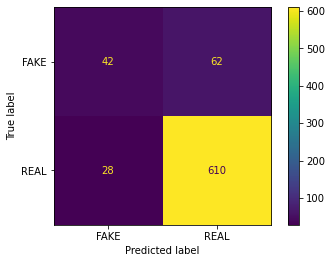

In [135]:
plot_confusion_matrix(Tree_tfidf_im, tfidf_test, y_test);

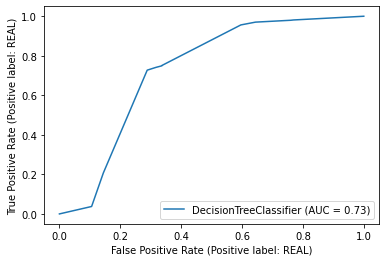

In [136]:
plot_roc_curve(Tree_tfidf_im ,tfidf_test, y_test);

Accuracy is not deviating too much from the dummy model so we need improvement in our model.